In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uyennguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Load the train.csv
df = pd.read_csv('../data/raw/train.csv')  # adjust path if needed
print(df.shape)
df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
# Check number of null values
print(df.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [15]:
# Check number of duplicates
num_duplicates = df.duplicated(subset='comment_text').sum()
print(f"Number of duplicate comments: {num_duplicates}")

Number of duplicate comments: 0


### Preprocessing

In [16]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    return text

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)


In [17]:
# Apply cleaning
df['clean_comment'] = df['comment_text'].apply(clean_text)
df[['comment_text', 'clean_comment']].head()

,comment_text,clean_comment
0,Explanation\nWhy the edits made under my usern...,explanation\nwhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more\ni cant make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [18]:
# Apply stopword removal
stop_words = set(stopwords.words('english'))
df['clean_comment'] = df['clean_comment'].apply(remove_stopwords)
df[['comment_text', 'clean_comment']].head()

,comment_text,clean_comment
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


In [21]:
# Replace empty strings with np.nan
df['clean_comment'] = df['clean_comment'].replace('', np.nan)

# Check number of null values
print(df['clean_comment'].isnull().sum())

# Drop NaNs
df = df.dropna(subset=['clean_comment'])
print("Shape after cleaning: ",df.shape)


64
Shape after cleaning:  (159507, 9)


Save preprocessed data

In [22]:
df.to_csv('../data/processed/train_clean.csv', index=False)

### EDA
Some important class distribution plots to look at before oversampling

#### Label Distribution

/var/folders/63/lvrmvc5j7pn6bxjxzcd1txt00000gn/T/ipykernel_53747/2768136669.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette="magma")


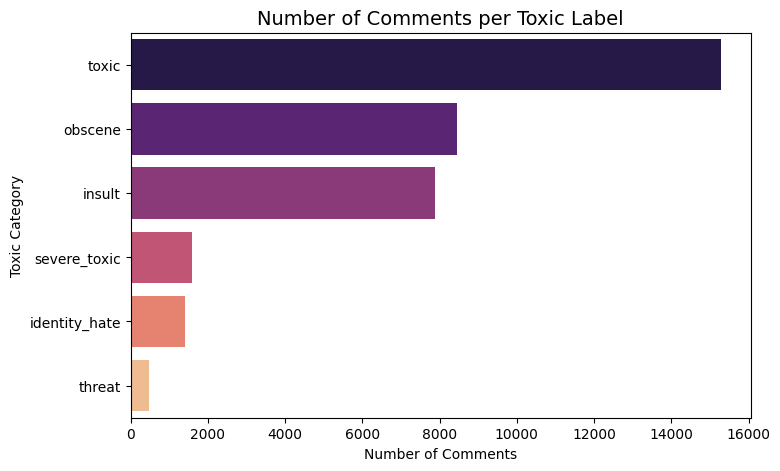

In [8]:
# Each label is a binary column: 0 (no) or 1 (yes)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Sum how many examples of each label
label_counts = df[label_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.values, y=label_counts.index, palette="magma")
plt.title("Number of Comments per Toxic Label", fontsize=14)
plt.xlabel("Number of Comments")
plt.ylabel("Toxic Category")
plt.show()


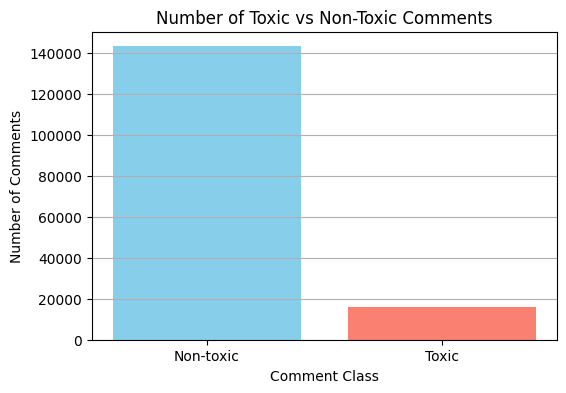

In [48]:
# Assuming your dataset is called df_balanced
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count number of labels per comment
df['num_labels'] = df[label_cols].sum(axis=1)

# Classify as toxic (>=1 label) or non-toxic (0 labels)
df['is_toxic'] = (df['num_labels'] > 0).astype(int)

# Count toxic vs non-toxic
class_counts = df['is_toxic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(['Non-toxic', 'Toxic'], class_counts, color=['skyblue', 'salmon'])
plt.title('Number of Toxic vs Non-Toxic Comments')
plt.xlabel('Comment Class')
plt.ylabel('Number of Comments')
plt.grid(axis='y')
plt.show()

#### Check Multi-Label Cases

/var/folders/63/lvrmvc5j7pn6bxjxzcd1txt00000gn/T/ipykernel_53747/592548360.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num_labels', data=df, palette="coolwarm")


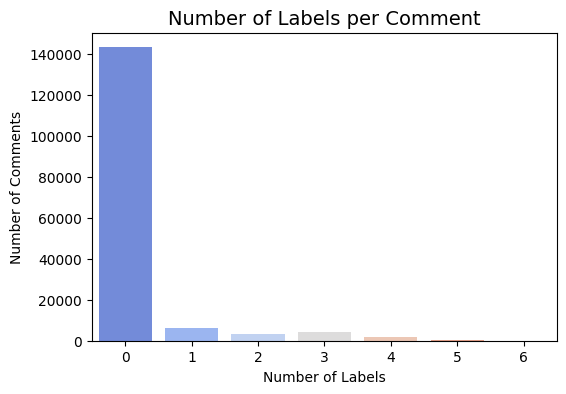

In [15]:
# Count how many labels each comment has
df['num_labels'] = df[label_cols].sum(axis=1)

# Plot number of labels per comment
plt.figure(figsize=(6,4))
sns.countplot(x='num_labels', data=df, palette="coolwarm")
plt.title("Number of Labels per Comment", fontsize=14)
plt.xlabel("Number of Labels")
plt.ylabel("Number of Comments")
plt.show()

In [ ]:
# Count how many labels each comment has
df_balanced['num_labels'] = df_balanced[label_cols].sum(axis=1)

# Plot number of labels per comment
plt.figure(figsize=(6,4))
sns.countplot(x='num_labels', data=df_balanced, palette="coolwarm")
plt.title("Number of Labels per Comment after Oversampling", fontsize=14)
plt.xlabel("Number of Labels")
plt.ylabel("Number of Comments")
plt.show()

### More EDA

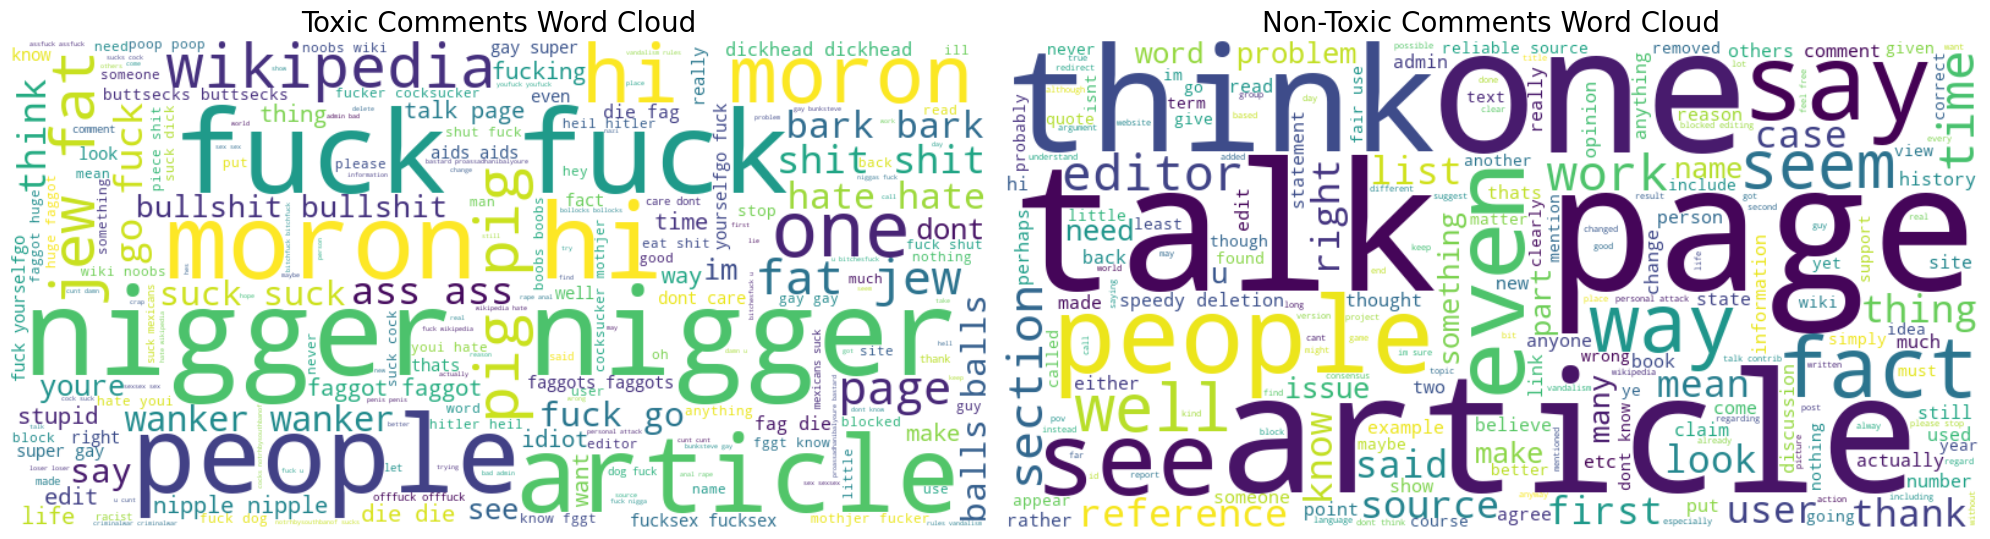

In [17]:
# Toxic comments text
toxic_text = " ".join(df[df['toxic'] == 1]['clean_comment'])

# Non-Toxic comments text
non_toxic_text = " ".join(df[df['toxic'] == 0]['clean_comment'])

# Generate word clouds
toxic_wc = WordCloud(width=800, height=400, background_color='white').generate(toxic_text)
non_toxic_wc = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_text)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Toxic
axes[0].imshow(toxic_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Toxic Comments Word Cloud', fontsize=20)

# Non-Toxic
axes[1].imshow(non_toxic_wc, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Non-Toxic Comments Word Cloud', fontsize=20)

plt.tight_layout()
plt.show()


[('fuck', 8615), ('shit', 3587), ('dont', 3528), ('like', 3477), ('nigger', 3289), ('wikipedia', 3263), ('fucking', 3193), ('suck', 3036), ('go', 2834), ('hate', 2614), ('ass', 2601), ('u', 2584), ('get', 2283), ('gay', 2223), ('know', 2182), ('page', 2116), ('die', 2077), ('im', 2035), ('fat', 1967), ('faggot', 1957)]


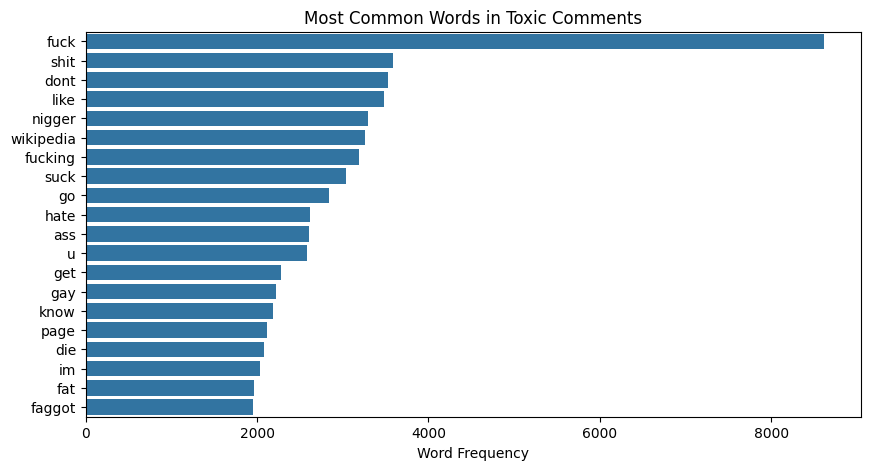

In [ ]:
# Tokenize all toxic clean comments
toxic_words = " ".join(df[df['toxic'] == 1]['clean_comment']).split()

# Count word frequencies
word_counts = Counter(toxic_words)

# Most common words
common_words = word_counts.most_common(20)
print(common_words)

# Plot
words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title("Most Common Words in Toxic Comments")
plt.xlabel("Word Frequency")
plt.show()

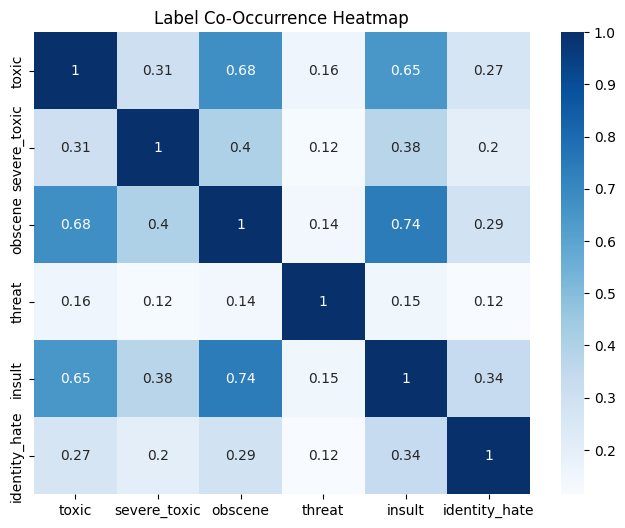

In [20]:
# Find co-occurrence
co_occurrence = df[label_cols].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(co_occurrence, annot=True, cmap="Blues")
plt.title("Label Co-Occurrence Heatmap")
plt.show()

### Oversampling

In [42]:
# Load cleaned data
df = pd.read_csv('../data/processed/train_clean.csv')
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# 1. Print class distribution BEFORE oversampling
print("Class distribution before oversampling:")
print(df[label_cols].sum())

# Define rare classes to oversample
rare_labels = ['threat', 'identity_hate', 'severe_toxic']

# Oversample ratios
oversample_ratio_default = 10  # For identity_hate, severe_toxic
oversample_ratio_threats = 50   # Specific for threat

# Container for oversampled DataFrames
oversampled_dfs = []

for label in rare_labels:
    rare_samples = df[df[label] == 1]

    if label == 'threat':
        oversampled = pd.concat([rare_samples] * oversample_ratio_threats, ignore_index=True)
    else:
        oversampled = pd.concat([rare_samples] * oversample_ratio_default, ignore_index=True)

    oversampled_dfs.append(oversampled)

# Combine all oversampled rare examples
oversampled_rare = pd.concat(oversampled_dfs, ignore_index=True)

# Combine back with the original DataFrame
df_balanced = pd.concat([df, oversampled_rare], ignore_index=True)

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Print class distribution AFTER oversampling
print("\nClass distribution after oversampling:")
print(df_balanced[label_cols].sum())

print("\nOriginal dataset size:", df.shape)
print("Balanced dataset size:", df_balanced.shape)

# Save the balanced dataset
df_balanced.to_csv('../data/processed/train_balanced.csv', index=False)



Class distribution before oversampling:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Class distribution after oversampling:
toxic            66714
severe_toxic     26275
obscene          48989
threat           26478
insult           48537
identity_hate    23485
dtype: int64

Original dataset size: (159507, 9)
Balanced dataset size: (213407, 9)


/var/folders/63/lvrmvc5j7pn6bxjxzcd1txt00000gn/T/ipykernel_54124/497117454.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette="magma")


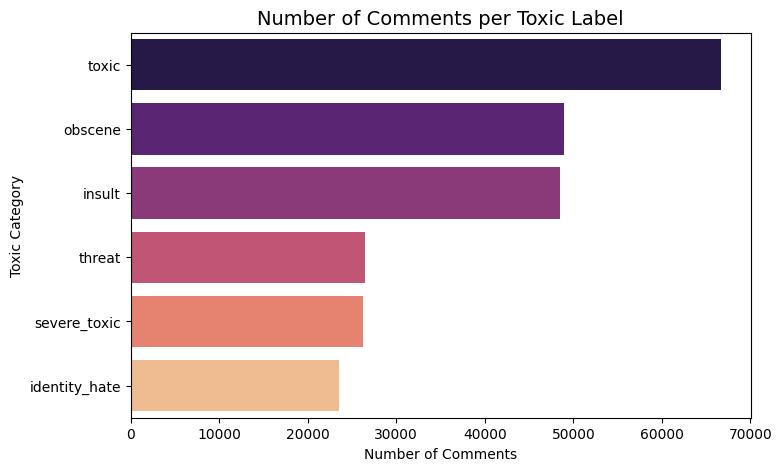

In [43]:
# Each label is a binary column: 0 (no) or 1 (yes)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Sum how many examples of each label
label_counts = df_balanced[label_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.values, y=label_counts.index, palette="magma")
plt.title("Number of Comments per Toxic Label", fontsize=14)
plt.xlabel("Number of Comments")
plt.ylabel("Toxic Category")
plt.show()


/var/folders/63/lvrmvc5j7pn6bxjxzcd1txt00000gn/T/ipykernel_54124/343319042.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num_labels', data=df_balanced, palette="coolwarm")


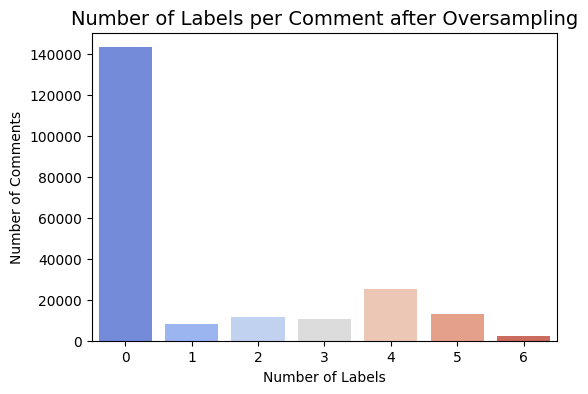

In [46]:
# Count how many labels each comment has
df_balanced['num_labels'] = df_balanced[label_cols].sum(axis=1)

# Plot number of labels per comment
plt.figure(figsize=(6,4))
sns.countplot(x='num_labels', data=df_balanced, palette="coolwarm")
plt.title("Number of Labels per Comment after Oversampling", fontsize=14)
plt.xlabel("Number of Labels")
plt.ylabel("Number of Comments")
plt.show()

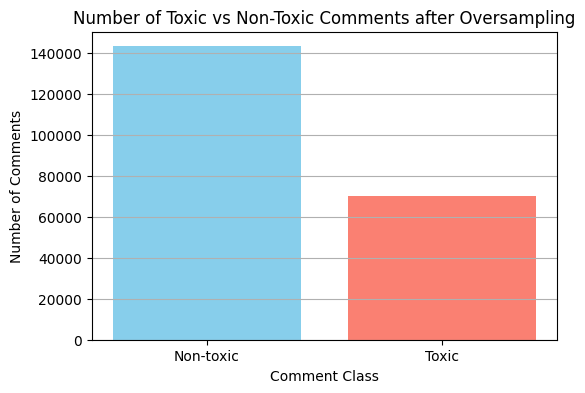

In [49]:
# Assuming your dataset is called df_balanced
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count number of labels per comment
df_balanced['num_labels'] = df_balanced[label_cols].sum(axis=1)

# Classify as toxic (>=1 label) or non-toxic (0 labels)
df_balanced['is_toxic'] = (df_balanced['num_labels'] > 0).astype(int)

# Count toxic vs non-toxic
class_counts = df_balanced['is_toxic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(['Non-toxic', 'Toxic'], class_counts, color=['skyblue', 'salmon'])
plt.title('Number of Toxic vs Non-Toxic Comments after Oversampling')
plt.xlabel('Comment Class')
plt.ylabel('Number of Comments')
plt.grid(axis='y')
plt.show()